In [63]:
#two level relu: max(x1, max(x2, 0))
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import time
# from torchviz import make_dot

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size = 1000#500
num_classes = 10
batch_size = 100
learning_rate = 0.001
num_workers=0

num_epochs = 5

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=False,
                                  download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle = True)

Epoch [1/5], Step [100/600], Loss: 1.5503
Epoch [1/5], Step [200/600], Loss: 1.2858
Epoch [1/5], Step [300/600], Loss: 1.3468
Epoch [1/5], Step [400/600], Loss: 1.5387
Epoch [1/5], Step [500/600], Loss: 1.3513
Epoch [1/5], Step [600/600], Loss: 1.1689
Epoch [2/5], Step [100/600], Loss: 1.2165
Epoch [2/5], Step [200/600], Loss: 1.2665
Epoch [2/5], Step [300/600], Loss: 1.2069
Epoch [2/5], Step [400/600], Loss: 1.1388
Epoch [2/5], Step [500/600], Loss: 1.1614
Epoch [2/5], Step [600/600], Loss: 1.3475
Epoch [3/5], Step [100/600], Loss: 1.0641
Epoch [3/5], Step [200/600], Loss: 1.4453
Epoch [3/5], Step [300/600], Loss: 1.3837
Epoch [3/5], Step [400/600], Loss: 1.3184
Epoch [3/5], Step [500/600], Loss: 1.2194
Epoch [3/5], Step [600/600], Loss: 1.2495
Epoch [4/5], Step [100/600], Loss: 0.9714
Epoch [4/5], Step [200/600], Loss: 1.1547
Epoch [4/5], Step [300/600], Loss: 1.1740
Epoch [4/5], Step [400/600], Loss: 1.0490
Epoch [4/5], Step [500/600], Loss: 1.2903
Epoch [4/5], Step [600/600], Loss:

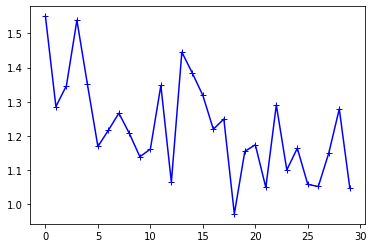

1.2249846716721853


In [64]:
def relu_min_max(input1, input2):
    '''this is sparse: two level-relu'''
    r1 = torch.max(input1, torch.zeros_like(input1))
    r2 = torch.max(input2, torch.zeros_like(input1))
    return torch.min(r1, r2)

def relu_max_min(input1, input2):
    '''this is sparse: two level-relu'''
    r1 = torch.min(input1, torch.zeros_like(input1))
    r2 = torch.min(input2, torch.zeros_like(input1))
    return torch.max(r1, r2)

class ReLU_my(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf
    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class
    
    def forward(self, input1, input2):
        '''
        Forward pass of the function.
        '''
        return relu_min_max(input1, input2)
#         return relu_max_min(input1, input2)

    
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        
        self.comp_units = round(hidden_size/4.0)

        self.fc1 = nn.Linear(input_size, self.comp_units) 
        self.fc2 = nn.Linear(input_size, self.comp_units) 
        self.relu = ReLU_my()
        self.fc3 = nn.Linear(self.comp_units, num_classes)  
    
    def forward(self, x):
        out = x
        
        out1 = self.fc1(out)
        out2 = self.fc2(out)
        
        out_relu = self.relu(out1, out2)
        out = self.fc3(out_relu)
        return out, out_relu  
#optionally add a sigmoid to the blocking; not sparse
#     def forward(self, x):
#         out = x
        
#         out1 = self.fc1(out)
#         out2 = self.fc2(out)
#         out2 = self.sigmoid(out2)
        
#         out_relu = self.relu(out1, out2)
#         out = self.fc3(out_relu)
#         return out, out_relu  

#now I can define my model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

#visualzing graphs
# writer=SummaryWriter('runs/experiment_1')
# dataiter=iter(train_loader)
# images, labels = dataiter.next()
# # print(images.shape)
# grid = torchvision.utils.make_grid(images)
# #writer.add_image('images', grid, 0)

# #images = images.reshape(-1, 28*28).to(device)
# dummy_input = torch.zeros(1, 28*28),
# writer.add_graph(model, dummy_input)
# writer.close()

start = time.time()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
losses=[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs, _  = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses.append(loss.item())
            

print('elapsed: ', time.time()-start)
plt.plot(losses, '-b+')
plt.show()
print(np.mean(losses))



In [62]:

#check dead neurons
dataiter=iter(train_loader)
images, labels = dataiter.next()
images = images.reshape(-1, 28*28).to(device)
# print(images.shape)
A1 = images[:100]
print("sample size: ", A1.shape)
output, output_relu = model(A1)

output_relu = output_relu.T.detach()
print(output_relu.shape)
# plt.plot(output_relu.numpy(), '-b+')
# plt.show()
print('np.count_nonzero(output_relu)=', np.count_nonzero(output_relu))
print('average nonzero neurons per input:', np.count_nonzero(output_relu)/A1.shape[0])
# print('sparsity percentage', 1- np.count_nonzero(output_relu)/ (output_relu.shape[0] * output_relu.shape[1]))
print('sparsity percentage', 1- np.count_nonzero(output_relu)/ (output_relu.shape[0] * output_relu.shape[1]))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
labels_wrong = []
pred_wrong = []
img_wrong = []
with torch.no_grad():
    correct = 0
    total = 0
    for img, labels in test_loader:
#         print(img.shape)
        images = img.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong_preds = (predicted != labels).numpy()
        wrong_index = []
        for (i, wrong) in enumerate(wrong_preds):
            if wrong:
                wrong_index.append(i) 
        if len(wrong_index) > 0:
            img_reshaped = img[wrong_index].numpy()[:,0,:,:]
            for img_w in range(img_reshaped.shape[0]):
                img_wrong.append(img_reshaped[img_w])
            labels_wrong  += (labels[wrong_index].numpy().tolist())
            pred_wrong += (predicted[wrong_index].numpy().tolist())
#     print(img_wrong)
#     print('img_wrong.shape', img_wrong[0].shape)
#     print('lables_wrong =', labels_wrong)
#     print('predictions wrong are:', pred_wrong)
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

#show wrong images:
# print(len(img_wrong), ', ', len(labels_wrong), ', ', len(pred_wrong))
# for i in range(len(img_wrong)):
#     plt.imshow(img_wrong[i])
#     print('labels_wrong[i]:', labels_wrong[i])
#     print('pred_wrong[i]', pred_wrong[i])
#     plt.pause(1)

# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

sample size:  torch.Size([100, 784])
torch.Size([250, 100])
np.count_nonzero(output_relu)= 15654
average nonzero neurons per input: 156.54
sparsity percentage 0.37383999999999995
Accuracy of the network on the 10000 test images: 97.75 %


In [277]:
print('layer 1:')
w_fc1 = list(model.fc1.parameters())
print(w_fc1)

print('layer 2:')
w_fc2 = list(model.fc2.parameters())
print(w_fc2)

[Parameter containing:
tensor([[-0.5779,  0.0640,  0.1430, -0.1617, -0.5140,  0.3530,  0.5737, -0.1477,
          0.1958, -0.1691],
        [ 0.4743,  0.2682, -0.5371, -0.1988,  0.2150, -0.6793, -0.1516,  0.6180,
         -0.3148, -0.7621],
        [ 0.2593, -0.1268, -0.0784,  0.0650,  0.3511, -0.3761,  0.4965, -0.7066,
          0.4375, -0.4512],
        [-0.4706,  0.6136, -0.5341, -0.2328,  0.5161, -0.2980, -0.2179, -0.1023,
          0.1481,  0.2383],
        [ 0.0301, -0.7920,  0.7271, -0.2208,  0.5299,  0.3283, -0.6619, -0.1630,
         -0.1853, -0.2730],
        [-0.7178, -0.2460, -0.3829, -0.0773,  0.0664,  0.3904, -0.1010,  0.4212,
          0.1781,  0.1411],
        [ 0.1937, -0.3704,  0.1585, -0.1834, -0.6606,  0.0736, -0.4391,  0.3063,
          0.6534, -0.7792],
        [ 0.3262,  0.5748,  0.1930, -0.1342, -0.3776,  0.3556,  0.1013, -0.6247,
         -0.7301,  0.2556],
        [ 0.2724, -0.5699, -0.5487,  0.0173,  0.0711,  0.0028, -0.0344,  0.0607,
          0.2700,  0.423

Accuracy of the network on the 10000 test images: 97.12 %


In [ ]:
#future work
def relu_at(A, threshold):
    return torch.max(A, torch.ones_like(A) * threshold)

def relu_min_at(A, threshold):
    return torch.min(A, torch.ones_like(A) * threshold)

class ThresholdingNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ThresholdingNet2, self).__init__()
        self.maxlu = ReLU_my()
        self.minlu = ReLU_min()
        self.fc1 = nn.Linear(input_size*2, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = x
        
        out1 = self.maxlu(out)
        out2 = self.minlu(out)
        out = torch.cat((out1, out2), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out  
    
# model = ThresholdingNet(input_size, hidden_size, num_classes).to(device)
model = ThresholdingNet2(input_size, hidden_size, num_classes).to(device)